# Raster Classification Map to Polygons
Michael Dear  
https://github.com/mjdear68  
August 2024

**Objective**: Convert a raster classification map to polygons.

In [17]:
%%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rioxarray
import numpy as np

UsageError: Cell magic `%%matplotlib` not found (But line magic `%matplotlib` exists, did you mean that instead?).


## Method
Repeat the following for each class in the dataset.
1. Create GoeDataFrame of points
2. Buffer the points
3. Get the bounds of the buffered points
4. Convert the bounds of a point to a polygon
5. Merge all touching "buffer polygons" into single polygons
6. Concatenate the results for each class to make the final GeoDataFrame

## Import and prepare the test data
The test data is part of a larger land cover classification map of the Hunter Estuary, NSW, Australia. The classification has seven levels:

class_num | class_name
--|--|
0 | No Data
1 | Water
2 | Developed
3 | Green Grass
4 | Brown Grass
5 | Swamp
6 | Wooded


There are no pixels in class 0 for the test set.

In [3]:
import xarray as xr
import rioxarray
import numpy as np
import pandas as pd
import geopandas as gpd

### Load the raster data to be converted to polygons.

In [4]:
da = rioxarray.open_rasterio('input/test.tiff', default_name='class')
da

<xarray.DataArray 'class' (band: 1, y: 100, x: 100)>
[10000 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.821e+06 1.821e+06 ... 1.824e+06 1.824e+06
  * y            (y) float64 -3.723e+06 -3.723e+06 ... -3.726e+06 -3.726e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:             Area
    STATISTICS_MAXIMUM:        6
    STATISTICS_MEAN:           3.9874
    STATISTICS_MINIMUM:        1
    STATISTICS_STDDEV:         1.5906103356888
    STATISTICS_VALID_PERCENT:  100
    scale_factor:              1.0
    add_offset:                0.0
    long_name:                 SVM_Class_linear

### Convert the xarray dataarray to a Pandas DataFrame of points.

In [5]:
df = da.to_dataframe().reset_index()
df.head()

,band,y,x,spatial_ref,class
0,1,-3722685.0,1821465.0,0,5
1,1,-3722685.0,1821495.0,0,4
2,1,-3722685.0,1821525.0,0,4
3,1,-3722685.0,1821555.0,0,5
4,1,-3722685.0,1821585.0,0,5


### Convert the data frame to a GeoDataFrame.

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
gdf.head()

,band,y,x,spatial_ref,class,geometry
0,1,-3722685.0,1821465.0,0,5,POINT (1821465.000 -3722685.000)
1,1,-3722685.0,1821495.0,0,4,POINT (1821495.000 -3722685.000)
2,1,-3722685.0,1821525.0,0,4,POINT (1821525.000 -3722685.000)
3,1,-3722685.0,1821555.0,0,5,POINT (1821555.000 -3722685.000)
4,1,-3722685.0,1821585.0,0,5,POINT (1821585.000 -3722685.000)


### Create a sorted list of class numbers.

In [7]:
class_nums = np.sort(gdf['class'].unique())
class_nums

array([1, 2, 3, 4, 5, 6], dtype=uint8)

## Custom Functions

In [67]:
def raster_polygon_plot(da, gdf, filename='raster_polygon_plot'):
    '''
    Side by side plot of original raster classification map and polygon classification map.
    da: the xarray dataarray containing the raster classification map
    gdf: the GeoPandas GeoDataFrame containing the vectory classification map
    '''
    fig, axes = plt.subplots(1,2, figsize=(8,5), sharey=True)
    da.plot(ax=axes[0], cmap='viridis', cbar_kwargs={'fraction':0.046, 'pad':0.04}) # colorbar height: https://stackoverflow.com/a/26720422
    gdf.boundary.plot(ax=axes[0], color='white', linewidth=0)
    axes[0].set_title('Raster')
    
    gdf.plot(ax=axes[1], cmap='viridis')
    gdf.boundary.plot(ax=axes[1], color='white', linewidth=0.5)
    axes[1].set_title('Polygons With Boundaries')
    
    for ax in axes:
        ax.axis('off')
    
    fig.savefig('output/'+filename+'.png')

## Step-by-step Version

### Imports

In [15]:
from shapely.geometry import Polygon
from shapely.ops import unary_union

### Proof of concept
In this section, a minimal GeoDataFrame is created and converted to polygons. This demonstrates that the method merges touching pixels correctly.

In [2]:
df_test = pd.DataFrame({'x': [0,1,3], 'y': [1,1,1]})

In [3]:
gdf_test = gpd.GeoDataFrame(df_test, geometry=gpd.points_from_xy(df_test.x, df_test.y))

<Axes: >

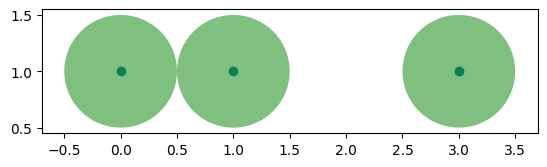

In [4]:
fig, ax = plt.subplots()
gdf_test.plot(ax=ax)
gdf_test.buffer(0.5).plot(ax=ax, color='green', alpha=0.5)

In [9]:
# Make a list to hold the pixel polygons
polygons = []

for row in gdf_test.index:
    # Get the X, Y coordinates of the point buffer bounds
    X1, Y1, X2, Y2 = gdf_test.iloc[[row]].buffer(0.5).total_bounds
    
    # Create the polygon; anti-clockwise from bottom-left
    polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
    print(polygon)
    polygons.append(Polygon(polygon))

# Unmerged pixel polygons
gdf_test_1 = gpd.GeoDataFrame(geometry=polygons)

# Merged pixel polygons
gdf_test_2 = gpd.GeoSeries(unary_union(polygons))

[(-0.5, 0.5), (0.5, 0.5), (0.5, 1.5), (-0.5, 1.5)]
[(0.5, 0.5), (1.5, 0.5), (1.5, 1.5), (0.5, 1.5)]
[(2.5, 0.5), (3.5, 0.5), (3.5, 1.5), (2.5, 1.5)]


<Axes: >

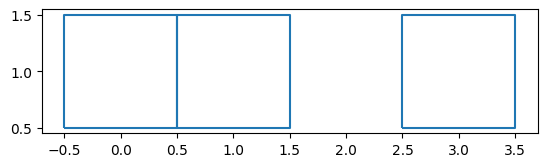

In [7]:
gdf_test_1.boundary.plot()

<Axes: >

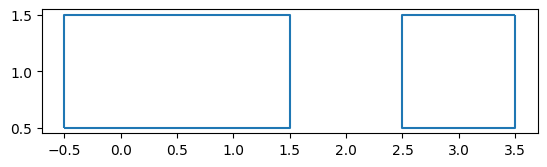

In [8]:
gdf_test_2.boundary.plot()

### Apply the method to the test data

In [16]:
%%time

class_gdfs = []
# classes = np.sort(gdf['class'].unique())

for class_num in class_nums:
    # Intialise the list for the pixel polygons
    pixel_polygons = []
    for row in gdf[gdf['class']==class_num].index:
        # Get the X, Y coordinates of the point buffer bounds
        X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(15).total_bounds
        
        # Create the polygon; anti-clockwise from bottom-left
        polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
        
        # Append pixel polygon to output list
        pixel_polygons.append(Polygon(polygon))

    # Convert pixel_polygons to gdf and append to class_gdfs
    # For unary_union() see https://stackoverflow.com/a/40386377/8299958
    class_gdfs.append(gpd.GeoSeries(unary_union(pixel_polygons)))
   
# Create the final GeoDataFrame
gdf_poly = gpd.GeoDataFrame(geometry=pd.concat(class_gdfs))

# Include a classes column
gdf_poly['class']=class_nums

# Set the crs to the data array crs
gdf_poly = gdf_poly.set_crs(da.rio.crs)

CPU times: total: 6.08 s
Wall time: 7.61 s


### Check the results

In [18]:
gdf_poly

,geometry,class
0,"MULTIPOLYGON (((1822170.000 -3725640.000, 1822...",1
0,"MULTIPOLYGON (((1821600.000 -3725670.000, 1821...",2
0,"MULTIPOLYGON (((1821450.000 -3725250.000, 1821...",3
0,"MULTIPOLYGON (((1821510.000 -3725160.000, 1821...",4
0,"MULTIPOLYGON (((1821480.000 -3725220.000, 1821...",5
0,"MULTIPOLYGON (((1821960.000 -3725610.000, 1821...",6


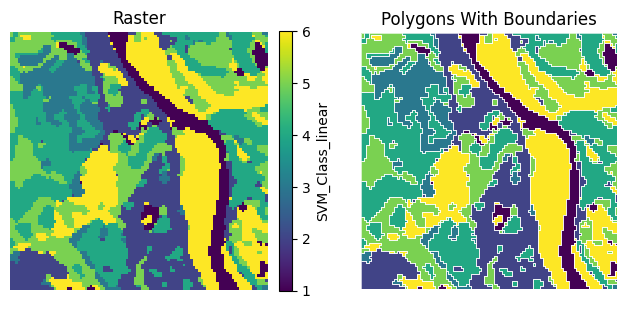

In [65]:
raster_polygon_plot(da, gdf_poly, 'raster_polygon_plot_test')

## Function Version

In [1]:
def raster_classes_to_polygons(da):
    '''
    Converts a raster classification map to polygons.
    da: the raster classification to convert; 
    da needs 
        - to be a xarray dataarray
        - have a name; this will be used to name the classification variable
        - have a crs; this will be the crs of the output geodataframe
    '''

    # Imports
    import matplotlib.pyplot as plt
    import pandas as pd
    import geopandas as gpd
    import rioxarray
    import numpy as np
    
    from shapely.geometry import Polygon
    from shapely.ops import unary_union

    # Get the class_var from the data array
    class_var = da.name
    
    # Convert the data array to a data frame
    df = da.to_dataframe().reset_index()

    # Convert the data frame to a geodataframe of points
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    # Get a list of the unique class numbers
    class_nums = np.sort(gdf[class_var].unique())

    #### Apply the method ####
    
    class_gdfs = []

    for class_num in class_nums:
        # Intialise the list for the pixel polygons
        pixel_polygons = []
        for row in gdf[gdf['class']==class_num].index:
            # Get the X, Y coordinates of the point buffer bounds
            X1, Y1, X2, Y2 = gdf.iloc[[row]].buffer(15).total_bounds
            
            # Create the polygon; anti-clockwise from bottom-left
            polygon = [(X1, Y1), (X2, Y1), (X2, Y2), (X1, Y2)]
            
            # Append pixel polygon to output list
            pixel_polygons.append(Polygon(polygon))
    
        # Convert pixel_polygons to gdf and append to class_gdfs
        # For unary_union() see https://stackoverflow.com/a/40386377/8299958
        class_gdfs.append(gpd.GeoSeries(unary_union(pixel_polygons)))
       
    # Create the final GeoDataFrame
    gdf_poly = gpd.GeoDataFrame(geometry=pd.concat(class_gdfs))
    
    # Include a classes column
    gdf_poly['class']=class_nums
    
    # Set the crs to the data array crs
    gdf_poly = gdf_poly.set_crs(da.rio.crs)

    return gdf_poly

### Apply the function

In [8]:
%%time
gdf_poly = raster_classes_to_polygons(da)

### Check the results

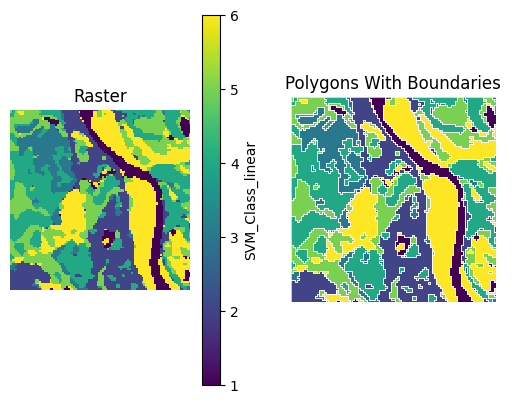

In [61]:
raster_polygon_plot(da, gdf_poly, 'raster_polygon_plot_test')

## Apply to a larger data array

In [12]:
da2 = rioxarray.open_rasterio('input/full.tiff', default_name='class')
da2

<xarray.DataArray 'class' (band: 1, y: 496, x: 779)>
[386384 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.812e+06 1.812e+06 ... 1.836e+06 1.836e+06
  * y            (y) float64 -3.717e+06 -3.717e+06 ... -3.732e+06 -3.732e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      class

### Apply the function

In [13]:
%%time
gdf_poly2 = raster_classes_to_polygons(da2)

### Check the results

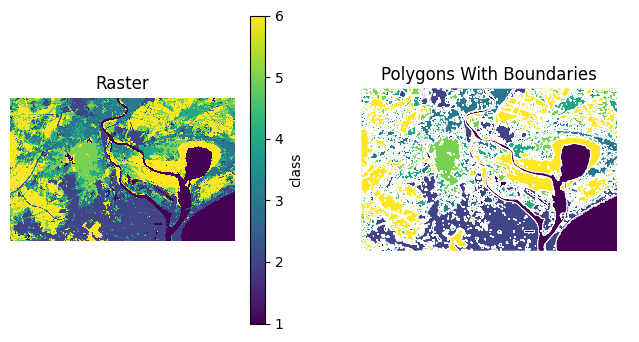

In [59]:
raster_polygon_plot(da2, gdf_poly2, 'raster_polygon_plot_full')

## Write to file

In [18]:
gdf_poly.to_file('output/class_polygons_test.geojson', driver='GeoJSON')

In [19]:
gdf_poly2.to_file('output/class_polygons_full.geojson', driver='GeoJSON')

## Conclusion
This method converts all pixels correctly. However, it has a long run time for a larger datasets. Also, the polygon files are much larger than the original raster files. For example, class_polygons_full/full.tiff $= 4.83/1.47 = 3.29$ times larger. The advantage of polygons is their ease of use in combination with other geospatial data.

## Acknowledgements
* https://stackoverflow.com/a/72310089/8299958 and https://stackoverflow.com/a/68762419/8299958 for converting pixel buffer bounding boxes into polygons using `Polygon(polygon)`
* https://stackoverflow.com/a/40386377/8299958 for the use of `unary_union()` to merge touching pixel polygons